In [1]:
!nvidia-smi

Tue Nov 30 19:24:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 66%   67C    P2   317W / 350W |   9165MiB / 24267MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    On   | 00000000:21:00.0 Off |                  Off |
| 30%   

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


Here we shall plot the number of samples in each class.\
In CIFAR10 dataset the samples are balanced at 5000 samples per class.\
We will also define a function long tail that shall convert the\
balanced dataset into an unbalanced one given a dataset imbalance factor lamda.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_data_distribution(dataset, keyname="no name"):
    num_classes = len(dataset.classes)
    dataset_elems = num_classes*[0]
    for image, label in dataset:
        dataset_elems[label]+=1
    plt.bar(list(dataset.classes), dataset_elems)
    plt.title(keyname)
    plt.show()

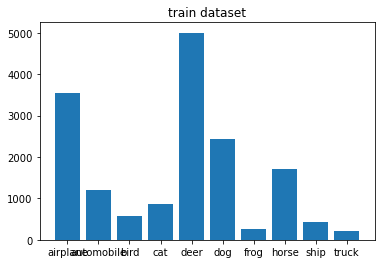

In [19]:
import random
def long_tail(dataset, lamda=1):
    num_classes = len(dataset.classes)
    class_indices = list(range(num_classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset


imabalanced_trainset = long_tail(trainset, lamda = 0.7)
show_data_distribution(imabalanced_trainset, keyname="train dataset")

In the training loop, we will be providing the optimizer, model,\
dataloader and the criterion i.e the loss function. We shall\
calculate a running loss that averages over the entire epoch and logs the same

In [20]:
def train(trainloader, optimizer, net, criterion, epoch):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            pass

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = (running_loss * i + loss.item())/(i + 1)

    print("Finished Training Epoch :", epoch, " With the running loss : ", running_loss)
    return net

In [21]:
def test(testloader, net):
    net.eval()
    output_logs = []
    label_logs = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
        else:
            pass
        
        labels = labels.numpy()
        outputs = torch.argmax(net(inputs), dim=1).cpu().detach().numpy()
        output_logs.append(outputs)
        label_logs.append(labels)
    print("Finished testing")
    return (np.concatenate(output_logs, axis=0), np.concatenate(label_logs, axis=0))

In the following function we shall feed all the outputs and the labels\
and the get metrics function shall return the following metrics of performance\
1. precision score class wise
2. max precision accross all class epochwise
3. min precision accross all class epochwise
4. mean precision *unweighted
5. recall score class wise
6. max recall accross all class epochwise
7. min recall accross all class epochwise
8. mean recall *unweighted
8. accuracy accross all class epochwise

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def get_metrics(outputs, labels):
    precision = precision_score(labels, outputs, average=None)
    max_precision = np.max(precision)
    min_precision = np.min(precision)
    mean_precision = np.mean(precision)
    
    recall = recall_score(labels, outputs, average=None)
    max_recall = np.max(recall)
    min_recall = np.min(recall)
    mean_recall = np.mean(recall)
    
    accuracy = accuracy_score(labels, outputs)
    return {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "max_precision": max_precision,
            "mean_precision": mean_precision,
            "min_precision": min_precision,
            "max_recall": max_recall,
            "mean_recall": mean_recall,
            "min_recall": min_recall
            }

In [26]:
def loop(trainloader, testloader, net, optimizer, criterion, epochs=50):
    logs = []
    for i in range(epochs):
        net = train(trainloader, optimizer, net, criterion, epoch=i)
        outputs, labels = test(testloader, net)
        metrics = get_metrics(outputs, labels)
        logs.append(metrics)
    return logs

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_log(logs, lamda, num_classes=10, classes=classes):
    print(classes)
    precision = [x['precision'] for x in logs]
    recall = [x['recall'] for x in logs]
    accuracy = [x['accuracy'] for x in logs]

    len_logs = len(accuracy)

    max_precision = [x['max_precision'] for x in logs]
    min_precision = [x['min_precision'] for x in logs]
    mean_precision = [x['mean_precision'] for x in logs]

    max_recall = [x['max_recall'] for x in logs]
    min_recall = [x['min_recall'] for x in logs]
    mean_recall = [x['mean_recall'] for x in logs]

    plt.plot(list(range(len(max_precision))), max_precision, label = "max_precision")
    plt.plot(list(range(len(min_precision))), min_precision, label = "min_precision")
    plt.plot(list(range(len(mean_precision))), mean_precision, label = "mean_precision")

    plt.plot(list(range(len(max_recall))), max_recall, label = "max_recall")
    plt.plot(list(range(len(min_recall))), min_recall, label = "min_recall")
    plt.plot(list(range(len(mean_recall))), mean_recall, label = "mean_recall")
    
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title(' min mean and max precision and recalls for class imbalance rate  '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    
    precision = np.array(precision)
    recall = np.array(recall)
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), precision[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Precision classwise')
    plt.title('Class wise precision for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), recall[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Recall classwise')
    plt.title('Class wise recall for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(list(range(len(accuracy))), accuracy, label = "accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('Class wise accuracy for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

In [30]:
class Resnet18cifar(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.resnet18 = torch.hub.load('pytorch/vision:v0.8.0', 'resnet18', pretrained=pretrained)
        self.base = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))
        self.fc = torch.nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.base(x)
        x = x.reshape((-1, 512))
        x = self.fc(x)
        return x

TRAINING WITH CLASS IMBALANCE FACTOR :  1.0
Files already downloaded and verified
Files already downloaded and verified


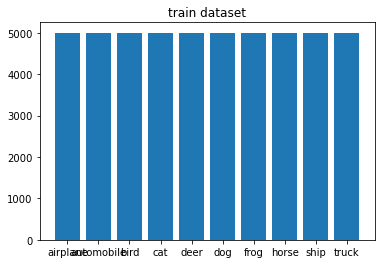

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


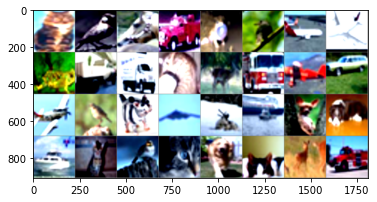

  cat  bird horse truck  frog  bird airplane airplane  frog truck truck   cat  deer truck airplane automobile airplane  bird   cat airplane  deer  ship   dog   dog  ship   cat  bird   cat   dog   cat  deer truck
length of trainset 50000


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  0.9155601611598052
Finished testing
Finished Training Epoch : 1  With the running loss :  0.6945868212674874
Finished testing
Finished Training Epoch : 2  With the running loss :  0.6617340742683685
Finished testing
Finished Training Epoch : 3  With the running loss :  0.6452121714598389
Finished testing
Finished Training Epoch : 4  With the running loss :  0.6365733785424875
Finished testing
Finished Training Epoch : 5  With the running loss :  0.6309648264754836
Finished testing
Finished Training Epoch : 6  With the running loss :  0.6236271035171663
Finished testing
Finished Training Epoch : 7  With the running loss :  0.6221108918226612
Finished testing
Finished Training Epoch : 8  With the running loss :  0.6117273921567666
Finished testing
Finished Training Epoch : 9  With the running loss :  0.6093052587521364
Finished testing
Finished Training Epoch : 10  With the running loss :  0.6102577315944929
Finished testing
Finished 

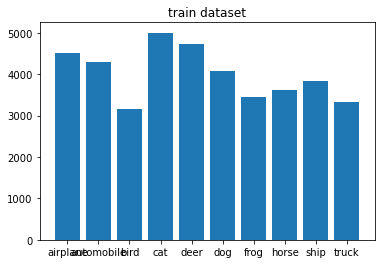

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


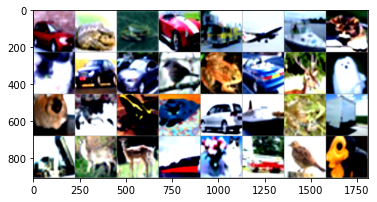

automobile  frog  frog automobile truck airplane  ship   cat   cat automobile automobile  bird  frog automobile  deer   dog   dog   cat  frog   cat automobile  ship  frog truck truck  deer  deer  ship   cat truck  bird  bird
length of trainset 39996


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  0.9640609888315197
Finished testing
Finished Training Epoch : 1  With the running loss :  0.7192792115211483
Finished testing
Finished Training Epoch : 2  With the running loss :  0.6809025633096701
Finished testing
Finished Training Epoch : 3  With the running loss :  0.6626935343742367
Finished testing
Finished Training Epoch : 4  With the running loss :  0.648002657914161
Finished testing
Finished Training Epoch : 5  With the running loss :  0.6398778101801882
Finished testing
Finished Training Epoch : 6  With the running loss :  0.6329943746328359
Finished testing
Finished Training Epoch : 7  With the running loss :  0.6264424700498576
Finished testing
Finished Training Epoch : 8  With the running loss :  0.6260851984620098
Finished testing
Finished Training Epoch : 9  With the running loss :  0.6172555975914003
Finished testing
Finished Training Epoch : 10  With the running loss :  0.619137949168682
Finished testing
Finished Tr

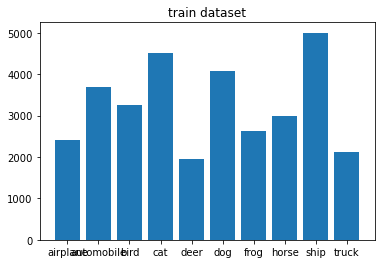

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


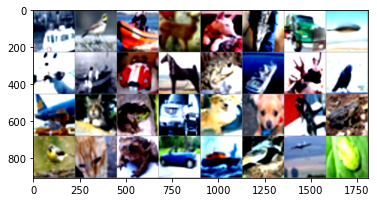

 ship  bird  ship  deer   dog  bird truck airplane horse  ship automobile horse  frog  ship  deer  bird airplane   cat  frog automobile   dog   dog   cat  frog  bird   cat  frog automobile  ship  bird airplane  frog
length of trainset 32631


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  0.976664904665713
Finished testing
Finished Training Epoch : 1  With the running loss :  0.7141865964321533
Finished testing
Finished Training Epoch : 2  With the running loss :  0.6650055807595162
Finished testing
Finished Training Epoch : 3  With the running loss :  0.6489792667037123
Finished testing
Finished Training Epoch : 4  With the running loss :  0.6343600523091997
Finished testing
Finished Training Epoch : 5  With the running loss :  0.6301063461338773
Finished testing
Finished Training Epoch : 6  With the running loss :  0.6180474577435091
Finished testing
Finished Training Epoch : 7  With the running loss :  0.6082133688324813
Finished testing
Finished Training Epoch : 8  With the running loss :  0.6051072413722677
Finished testing
Finished Training Epoch : 9  With the running loss :  0.6015182475979419
Finished testing
Finished Training Epoch : 10  With the running loss :  0.5970480028320765
Finished testing
Finished T

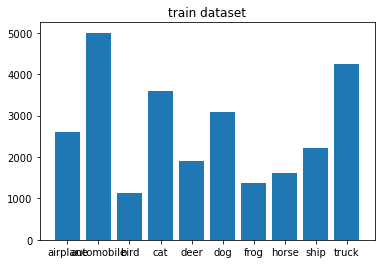

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


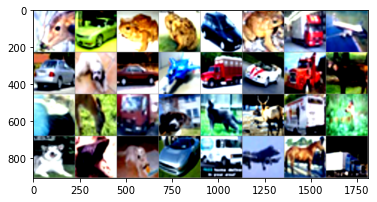

 deer automobile  frog  frog automobile  frog truck airplane automobile   dog automobile airplane truck automobile truck  deer   cat  deer truck   dog   cat  deer truck  deer   dog  frog   dog automobile truck airplane horse truck
length of trainset 26739


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  0.9789692778407686
Finished testing
Finished Training Epoch : 1  With the running loss :  0.6945931480475587
Finished testing
Finished Training Epoch : 2  With the running loss :  0.6418798137367057
Finished testing
Finished Training Epoch : 3  With the running loss :  0.6221237920367264
Finished testing
Finished Training Epoch : 4  With the running loss :  0.6056443108112047
Finished testing
Finished Training Epoch : 5  With the running loss :  0.5901271344371966
Finished testing
Finished Training Epoch : 6  With the running loss :  0.5809335461929082
Finished testing
Finished Training Epoch : 7  With the running loss :  0.5780923536234491
Finished testing
Finished Training Epoch : 8  With the running loss :  0.5737897545348796
Finished testing
Finished Training Epoch : 9  With the running loss :  0.5660736920695275
Finished testing
Finished Training Epoch : 10  With the running loss :  0.5587801360413794
Finished testing
Finished 

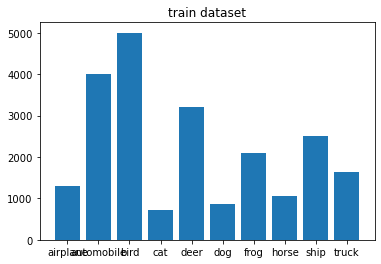

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


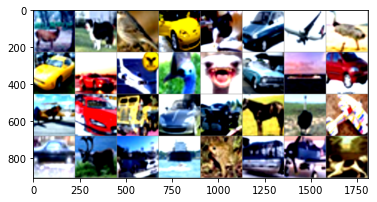

 deer   dog  bird automobile   cat automobile airplane  bird automobile automobile airplane  bird  bird automobile  ship automobile airplane automobile truck automobile truck horse  bird airplane automobile  deer  ship  ship  frog  ship airplane   dog
length of trainset 22382


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  1.003557767442294
Finished testing
Finished Training Epoch : 1  With the running loss :  0.6899939517463961
Finished testing
Finished Training Epoch : 2  With the running loss :  0.6390173028196602
Finished testing
Finished Training Epoch : 3  With the running loss :  0.6060657200642998
Finished testing
Finished Training Epoch : 4  With the running loss :  0.5935259530586857
Finished testing
Finished Training Epoch : 5  With the running loss :  0.5810682206281592
Finished testing
Finished Training Epoch : 6  With the running loss :  0.5642361039987646
Finished testing
Finished Training Epoch : 7  With the running loss :  0.5622643924823839
Finished testing
Finished Training Epoch : 8  With the running loss :  0.5558130399244181
Finished testing
Finished Training Epoch : 9  With the running loss :  0.5471917810610356
Finished testing
Finished Training Epoch : 10  With the running loss :  0.5457057145663669
Finished testing
Finished T

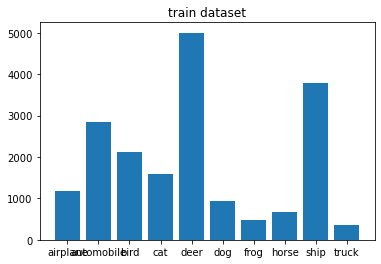

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


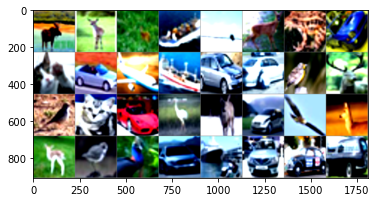

 deer  deer  deer  ship  bird  deer  frog automobile   cat automobile airplane  ship automobile automobile  bird  deer  bird   cat automobile  bird  deer automobile  bird  deer  deer  bird  bird automobile  ship automobile automobile automobile
length of trainset 18954


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  1.0119069619685346
Finished testing
Finished Training Epoch : 1  With the running loss :  0.695732047193971
Finished testing
Finished Training Epoch : 2  With the running loss :  0.6335841945763586
Finished testing
Finished Training Epoch : 3  With the running loss :  0.6017731908350739
Finished testing
Finished Training Epoch : 4  With the running loss :  0.5799376957533131
Finished testing
Finished Training Epoch : 5  With the running loss :  0.5719811604256168
Finished testing
Finished Training Epoch : 6  With the running loss :  0.5621593577966321
Finished testing
Finished Training Epoch : 7  With the running loss :  0.5565964008915473
Finished testing
Finished Training Epoch : 8  With the running loss :  0.5480385676755062
Finished testing
Finished Training Epoch : 9  With the running loss :  0.5412157571687661
Finished testing
Finished Training Epoch : 10  With the running loss :  0.52799602589157
Finished testing
Finished Tra

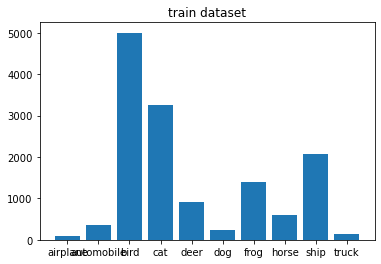

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


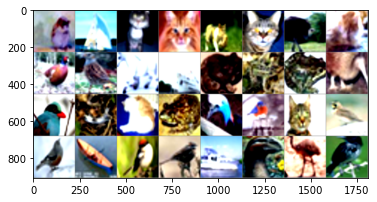

 bird  ship   cat   cat   cat   cat  bird   cat  bird  bird horse  ship  frog  frog  frog  bird  bird   cat   cat  frog  bird  bird   cat  bird  bird  ship  bird  bird  ship  bird  bird  bird
length of trainset 14072


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  1.0166006204079496
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  0.7296267633411018
Finished testing
Finished Training Epoch : 2  With the running loss :  0.6535231173715803
Finished testing
Finished Training Epoch : 3  With the running loss :  0.6248987839303237
Finished testing
Finished Training Epoch : 4  With the running loss :  0.6027070014314216
Finished testing
Finished Training Epoch : 5  With the running loss :  0.5793025001544844
Finished testing
Finished Training Epoch : 6  With the running loss :  0.5693044071847739
Finished testing
Finished Training Epoch : 7  With the running loss :  0.5622956508262593
Finished testing
Finished Training Epoch : 8  With the running loss :  0.5545164049349045
Finished testing
Finished Training Epoch : 9  With the running loss :  0.5432118951258328
Finished testing
Finished Training Epoch : 10  With the running loss :  0.536029935154048
Finished testing
Finished Training Epoch : 11  With the running loss :  0.5384428941729397
Finished testing
Finished 

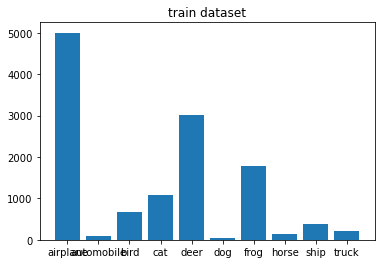

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


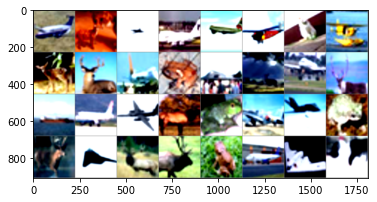

airplane   cat airplane airplane airplane airplane   cat airplane  deer  deer airplane  frog airplane  deer airplane  deer  ship airplane airplane  deer  frog airplane airplane  frog  deer airplane  deer  deer  frog airplane airplane   cat
length of trainset 12433


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  0.9008015092356957
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  0.638346257123972
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  0.5801399959236917
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  0.547198894397765
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  0.5346658057832475
Finished testing
Finished Training Epoch : 5  With the running loss :  0.511643286344325
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  0.49914225081704927
Finished testing
Finished Training Epoch : 7  With the running loss :  0.49227440640675085
Finished testing
Finished Training Epoch : 8  With the running loss :  0.4832267773871557
Finished testing
Finished Training Epoch : 9  With the running loss :  0.47063761256194664
Finished testing
Finished Training Epoch : 10  With the running loss :  0.4713920780043369
Finished testing
Finished Training Epoch : 11  With the running loss :  0.4671860885420924
Finished testing
Finished Training Epoch : 12  With the running loss :  0.45797804185694474
Finished testing
Finished Training Epoch : 13  With the running loss :  0.45711963365194425
Finished testing
Finished Training Epoch : 14  With the running loss :  0.45552879679172387
Finished testing
Finished Training Epoch : 15  With the running loss :  0.44263163844846515
Finished testing
Finished Training Epoch : 16  With the running loss :  0.445651822539099
Finished testi

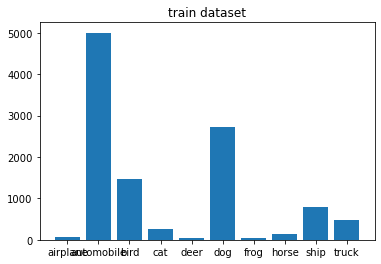

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


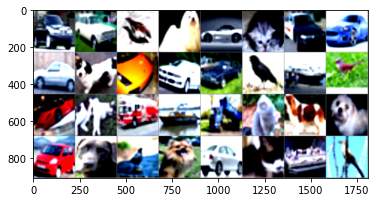

automobile automobile  bird   dog automobile   cat automobile automobile automobile   dog automobile automobile automobile  bird  ship  bird automobile   cat truck  ship truck   cat   dog   dog automobile   dog  bird   dog automobile   cat  ship  bird
length of trainset 10992


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  0.7552825569413433
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  0.49623924303193484
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  0.44172160539689453
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  0.406865904410911
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  0.3911142404039584
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  0.3765438106344189
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  0.36740250012642417
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  0.3553827701266422
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  0.34958536715008515
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  0.34131691886415316
Finished testing
Finished Training Epoch : 10  With the running loss :  0.3354201087251649
Finished testing
Finished Training Epoch : 11  With the running loss :  0.3229457368467784
Finished testing
Finished Training Epoch : 12  With the running loss :  0.3240469061921157
Finished testing
Finished Training Epoch : 13  With the running loss :  0.31305999109564836
Finished testing
Finished Training Epoch : 14  With the running loss :  0.3180007635680741
Finished testing
Finished Training Epoch : 15  With the running loss :  0.3098835528849866
Finished testing
Finished Training Epoch : 16  With the running loss :  0.30958581588036105
Finished testing
Finished Training Epoch : 17  With the running loss :  0.30786635685538843
Finished testing
Finished Training Epoch : 18  With the running loss :  0.30134341289657507
Finished testing
Finished Training Epoch : 19  With the running loss :  0.2986597896250357
Finished tes

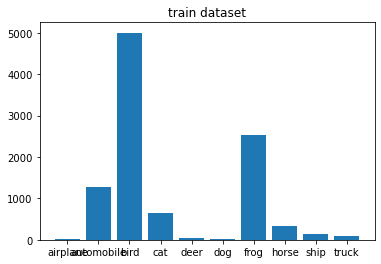

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


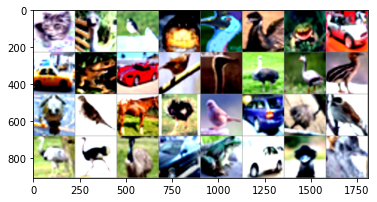

  cat  bird  bird  frog  bird  bird  frog automobile automobile  frog automobile  bird  bird  bird  bird  bird  frog  bird horse  bird  bird automobile  bird  bird  bird  bird  bird automobile  frog automobile  bird  bird
length of trainset 10104


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  0.7855517607700969
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  0.5427113804919059
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  0.48723047792534246
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  0.4553701088681251
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  0.4467742568990098
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  0.4281429704514486
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  0.4200852980625026
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  0.4023651470772073
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  0.39778281630405893
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  0.38687155365095105
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  0.38712388045991536
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  0.3849761456109678
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  0.3776438361198841
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  0.36478196831915205
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  0.3778831770148461
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  0.36498528233245947
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  0.36469423431384423
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  0.36692094345447385
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  0.3567195963114499
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  0.351568869161832
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  0.3522858609787272
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  0.3573924368601057
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  0.35177205182329
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  0.34860153873509997
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  0.3452810199719065
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  0.3407975464493412
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  0.3387302028227456
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  0.33888595581903463
Finished testing
Finished Training Epoch : 28  With the running loss :  0.3329020207865706
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  0.33216396188717107
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  0.333664095453635
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  0.3363922640351175
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  0.3270778744894116
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  0.33067767904434775
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  0.33023809867946397
Finished testing
Finished Training Epoch : 35  With the running loss :  0.3303039648770531
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  0.31896175602097293
Finished testing
Finished Training Epoch : 37  With the running loss :  0.3208339956553675
Finished testing
Finished Training Epoch : 38  With the running loss :  0.329979499401171
Finished testing
Finished Training Epoch : 39  With the running loss :  0.32642234682659577
Finished testing
Finished Training Epoch : 40  With the running loss :  0.3164515637945903
Finished testing
Finished Training Epoch : 41  With the running loss :  0.3225285403218262
Finished testing
Finished Training Epoch : 42  With the running loss :  0.33786520609467086
Finished testing
Finished Training Epoch : 43  With the running loss :  0.3201665597012904
Finished testing
Finished Training Epoch : 44  With the running loss :  0.31760174363757215
Finished testing
Finished Training Epoch : 45  With the running loss :  0.3207327461082348
Finished testing
Finished Training Epoch : 46  With the running loss :  0.3218992670432112
Finished test

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 48  With the running loss :  0.3058734201366393
Finished testing
Finished Training Epoch : 49  With the running loss :  0.3073958455337377
Finished testing


In [33]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL

logs_by_lamda_resnet18_cifar10_transfer_learning = []
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.Resize(256, PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

batch_size = 32

for lamda in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.65, 0.6, 0.55, 0.5]:
    print("TRAINING WITH CLASS IMBALANCE FACTOR : ", lamda)
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

    trainset = long_tail(trainset, lamda)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))

    net = Resnet18cifar(10)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=50)
    logs_by_lamda_resnet18_cifar10_transfer_learning.append({lamda: logs})

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  1.0
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


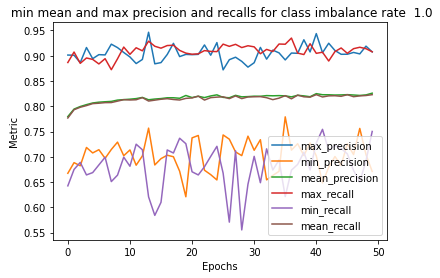

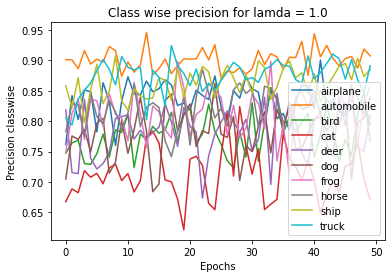

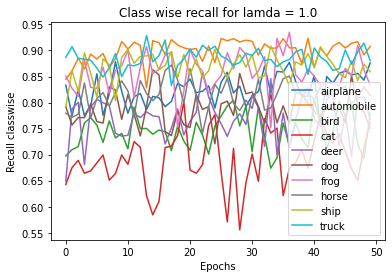

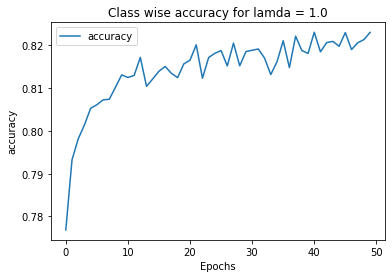

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.95
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


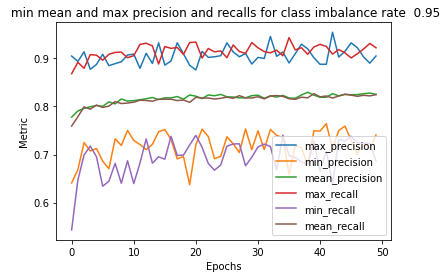

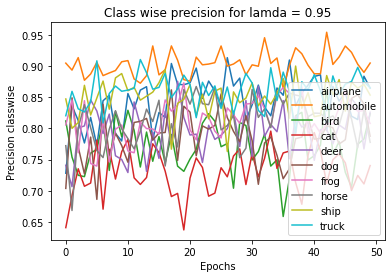

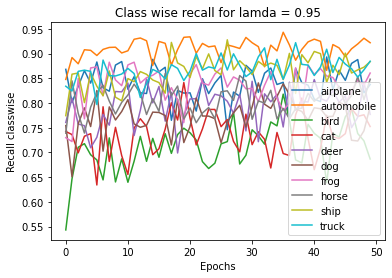

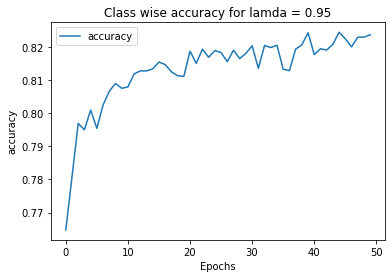

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.9
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


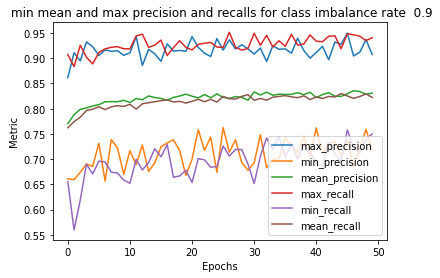

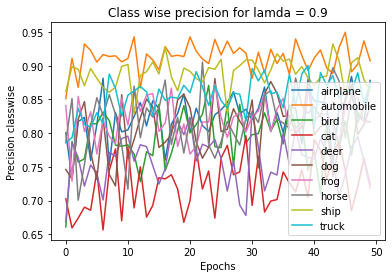

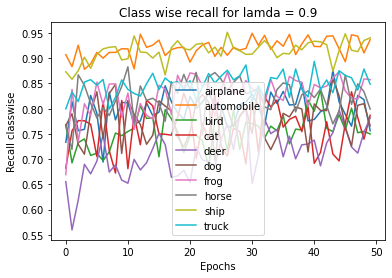

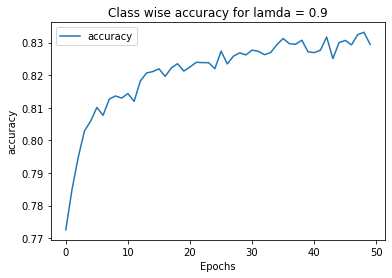

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.85
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


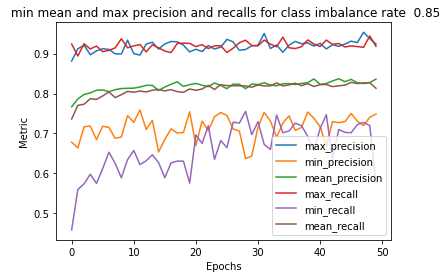

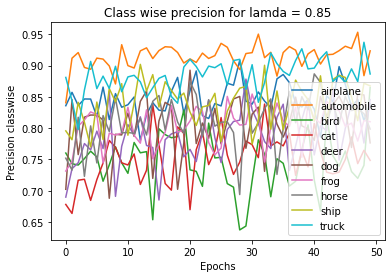

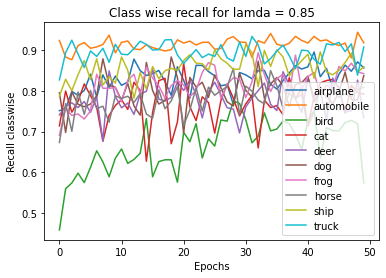

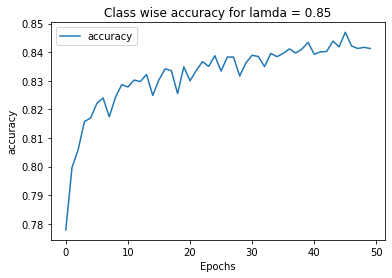

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.8
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


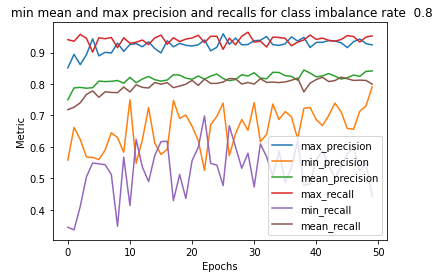

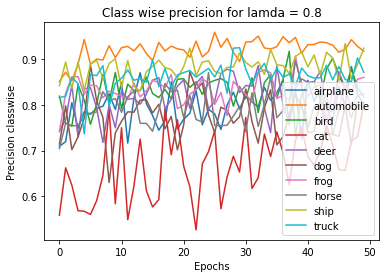

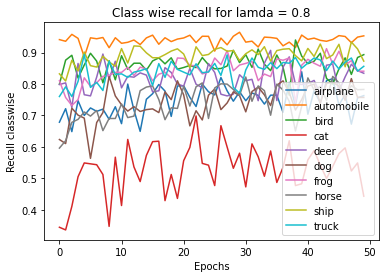

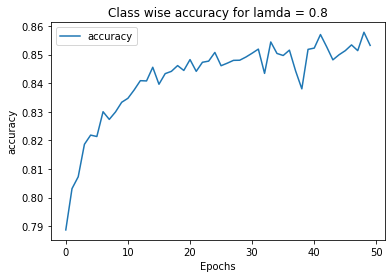

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.75
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


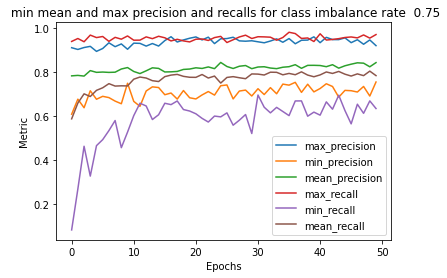

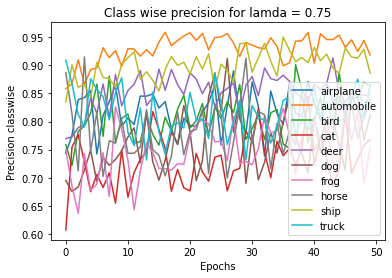

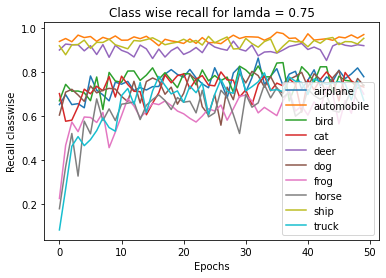

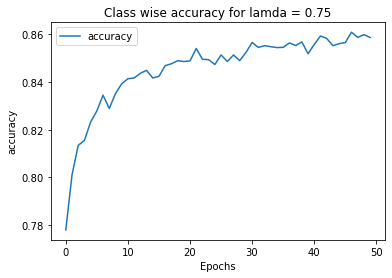

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.65
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


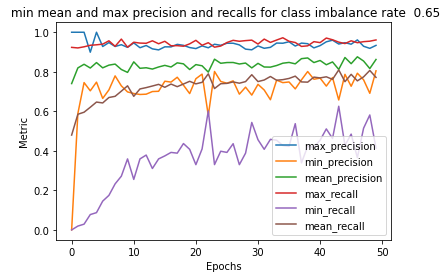

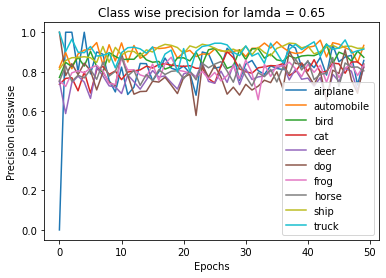

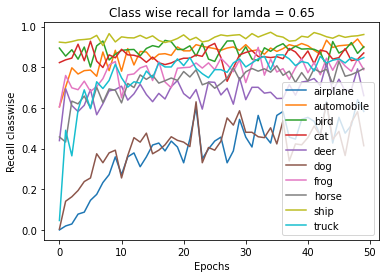

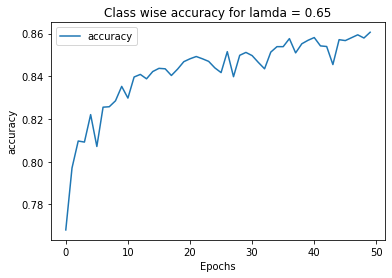

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.6
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


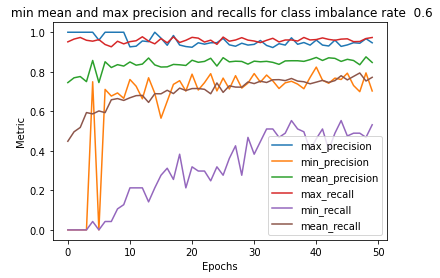

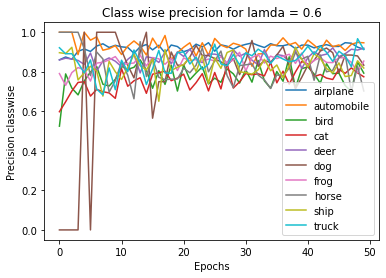

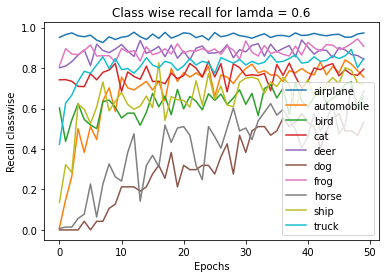

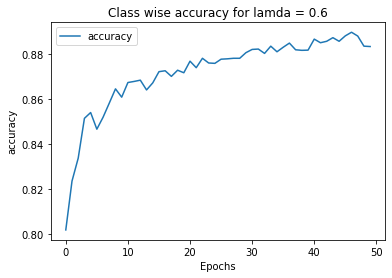

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.55
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


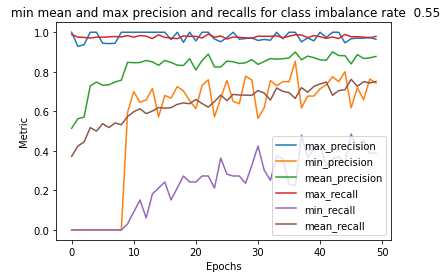

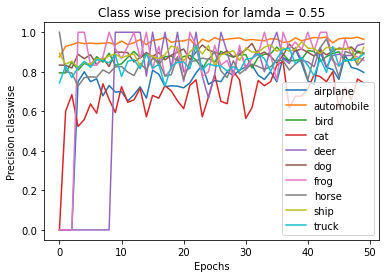

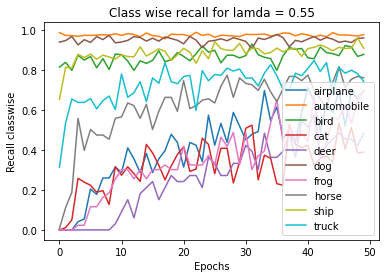

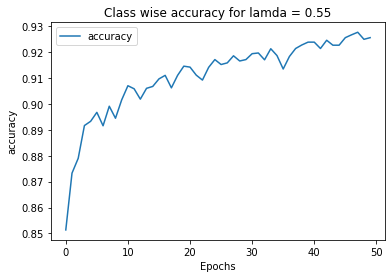

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.5
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


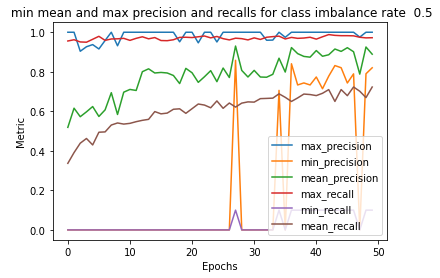

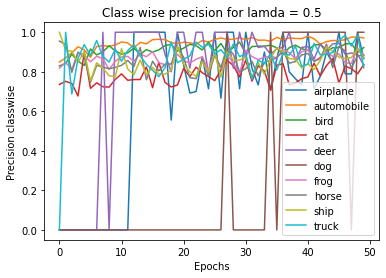

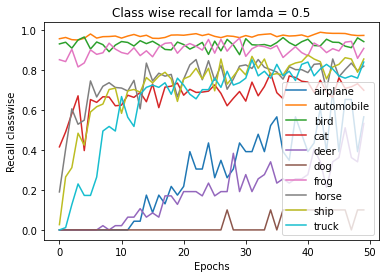

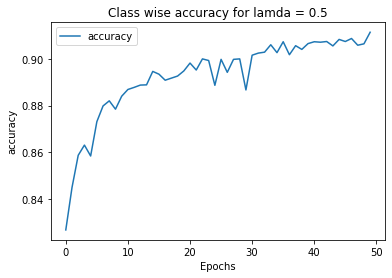

In [34]:
for log in logs_by_lamda_resnet18_cifar10_transfer_learning:
    lamda = list(log.keys())[0]
    log_data = log[lamda]
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    print("=" * 30)
    print("THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER")
    print("THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES")
    print("THE VALUE OF LAMDA IS ", lamda)
    print("=" * 30)
    plot_log(log_data, lamda, num_classes=len(trainset.classes), classes=trainset.classes)

In [ ]:
print(logs_by_lamda_resnet18_cifar10_transfer_learning)

In [22]:
class Resnet50cifar(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.resnet18 = torch.hub.load('pytorch/vision:v0.8.0', 'resnet50', pretrained=pretrained)
        self.base = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))
        self.fc = torch.nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.base(x)
        x = x.reshape((-1, 2048))
        x = self.fc(x)
        return x

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Files already downloaded and verified
Files already downloaded and verified


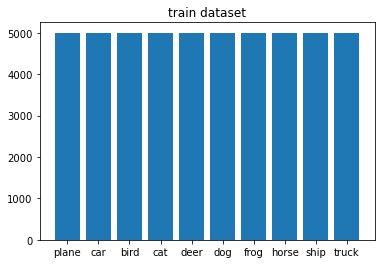

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


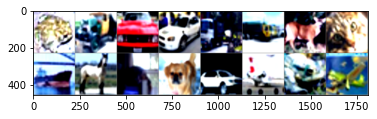

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


 frog truck   car   car truck truck  deer   cat  ship horse   cat   dog   car plane  frog plane
length of trainset 50000
Finished Training Epoch : 0  With the running loss :  0.8699088655877102
Finished testing
Finished Training Epoch : 1  With the running loss :  0.7021922852659219
Finished testing
Finished Training Epoch : 2  With the running loss :  0.6801156725835794
Finished testing
Finished Training Epoch : 3  With the running loss :  0.6640277353191353
Finished testing
Finished Training Epoch : 4  With the running loss :  0.6449089097428329
Finished testing
Finished Training Epoch : 5  With the running loss :  0.6358476763749135
Finished testing
Finished Training Epoch : 6  With the running loss :  0.6270259808373455
Finished testing
Finished Training Epoch : 7  With the running loss :  0.6201829726171494
Finished testing
Finished Training Epoch : 8  With the running loss :  0.6087416501379036
Finished testing
Finished Training Epoch : 9  With the running loss :  0.6110377478802

In [ ]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL

logs_by_lamda_resnet50_cifar10 = []
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.Resize(256, PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])


for lamda in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75]:
    batch_size = 16
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, 10, lamda)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))

    net = Resnet50cifar(10, pretrained=True)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=200)
    logs_by_lamda_resnet18_cifar10_transfer_learning.append({lamda: logs})